**Project Objective**

This project investigates the economic viability of installing a PEM electrolyzer system for on-site hydrogen production using dynamic electricity prices. The goal is to determine whether the investment in such a system is profitable, and if so, what size of electrolyzer and storage capacity would be optimal.

We simulate hourly hydrogen production based on historical electricity market prices and compare it to an internally defined hydrogen demand profile. The system only produces when electricity is cheap enough to be competitive with the market price of hydrogen. Surplus hydrogen can be stored or sold externally.

Key questions addressed:

    Is it economically viable to install a PEM electrolyzer under current market conditions?

    What is the optimal electrolyzer capacity for a given internal hydrogen demand?

    How much storage capacity is required to maximize self-sufficiency?

    How much of the demand can be covered using the system?

    What are the expected annual profits and amortization time?

This analysis forms the basis for a possible investment decision and can be used to support the next step: obtaining quotes for a real-world system implementation.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------
# 1. Load input data
# ----------------------------

#historical data from https://www.smard.de/home/downloadcenter/download-marktdaten/
file = 'Gro_handelspreise_202401010000_202502050000_Stunde.csv'
df = pd.read_csv(file, delimiter=';')

# Extract relevant Rows for Germany 
df = df[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
df.rename(columns={'Datum von': 'ds', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'y'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['ds'], format='%d.%m.%Y %H:%M')
df['price_eur_per_mwh'] = df['y'].str.replace(',', '.').astype(float)
df.sort_values('ds', inplace=True)
#print (df)

# ----------------------------
# 2. Set technical and economic parameters
# ----------------------------

# Technical parameters
efficiency = 0.7  # PEM electrolyzer efficiency (70%)
energy_content_per_kg_h2 = 33.3  # energy content of H2 in kWh/kg
electrolyzer_capacity_kw = 500  # installed capacity in kW
interval_hours = 1.0  # time resolution of the dataset

# Economic parameters
h2_sale_price = 5.0  # €/kg - internal value per kg produced
h2_buy_price = 7.0   # €/kg - external market purchase price
capex_per_kw = 1200  # €/kW - investment cost of PEM capacity
simulation_years = 1  # simulation duration in years

# Determine maximum electricity price that allows profitable production
max_eur_per_mwh = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

# ----------------------------
# 3. Simulate H2 demand profile
# ----------------------------
def simulate_demand(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# ----------------------------
# 4. Agent logic: produce only when electricity is cheap enough
# ----------------------------
def should_produce(price_mwh):
    return price_mwh <= max_eur_per_mwh

df['produce'] = df['price_eur_per_mwh'].apply(should_produce)
df['power_kw'] = df['produce'].astype(int) * electrolyzer_capacity_kw
df['energy_kwh'] = df['power_kw'] * interval_hours
df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2

# ----------------------------
# 5. Calculate economics of production
# ----------------------------
df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)
df['saved_costs_eur'] = df[['h2_kg', 'h2_demand_kg']].min(axis=1) * h2_buy_price
df['profit_eur'] = df['saved_costs_eur'] - df['cost_eur']

# ----------------------------
# 6. Evaluate coverage of demand
# ----------------------------
# At this point: no storage or H2 purchase fallback — just what is produced
df['actual_supply_kg'] = np.minimum(df['h2_demand_kg'], df['h2_kg'])
df['unmet_demand_kg'] = df['h2_demand_kg'] - df['actual_supply_kg']
df['unmet_demand_kg'] = df['unmet_demand_kg'].clip(lower=0)

# ----------------------------
# 7. Evaluate investment and profitability
# ----------------------------
total_production = df['h2_kg'].sum()
total_demand = df['h2_demand_kg'].sum()
total_supplied = df['actual_supply_kg'].sum()
total_unmet = df['unmet_demand_kg'].sum()
total_cost = df['cost_eur'].sum()
total_saved = df['saved_costs_eur'].sum()
total_profit = df['profit_eur'].sum()
capex_total = electrolyzer_capacity_kw * capex_per_kw
amortization_years = capex_total / total_profit if total_profit > 0 else np.inf

# ----------------------------
# 8. Output summary
# ----------------------------
print("--- Simulation Summary ---")
print(f"Simulation period: {simulation_years} year(s)")
print(f"Installed PEM capacity: {electrolyzer_capacity_kw} kW")
print(f"Total CAPEX investment: {capex_total:,.2f} €")
print(f"Total H₂ production: {total_production:,.2f} kg")
print(f"Total H₂ demand: {total_demand:,.2f} kg")
print(f"Supplied from own production: {total_supplied:,.2f} kg")
print(f"Unmet demand (not covered): {total_unmet:,.2f} kg")
print(f"Total electricity cost: {total_cost:,.2f} €")
print(f"Cost savings (vs. buying at {h2_buy_price} €/kg): {total_saved:,.2f} €")
print(f"Net annual profit: {total_profit:,.2f} €")
print(f"Amortization period: {amortization_years:.2f} years")


--- Simulation Summary ---
Simulation period: 1 year(s)
Installed PEM capacity: 500 kW
Total CAPEX investment: 600,000.00 €
Total H₂ production: 95,225.23 kg
Total H₂ demand: 42,506.00 kg
Supplied from own production: 38,880.00 kg
Unmet demand (not covered): 3,626.00 kg
Total electricity cost: 335,648.23 €
Cost savings (vs. buying at 7.0 €/kg): 272,160.00 €
Net annual profit: -63,488.23 €
Amortization period: inf years


**Preliminary Conclusion**
Here the capacity of the electrolyzer is too large. We need to find a good capacity for our needs.

C:\Users\velpTEC edutainment\AppData\Local\Temp\ipykernel_13540\2684475612.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2024-01-01', periods=hours_per_year, freq='H')


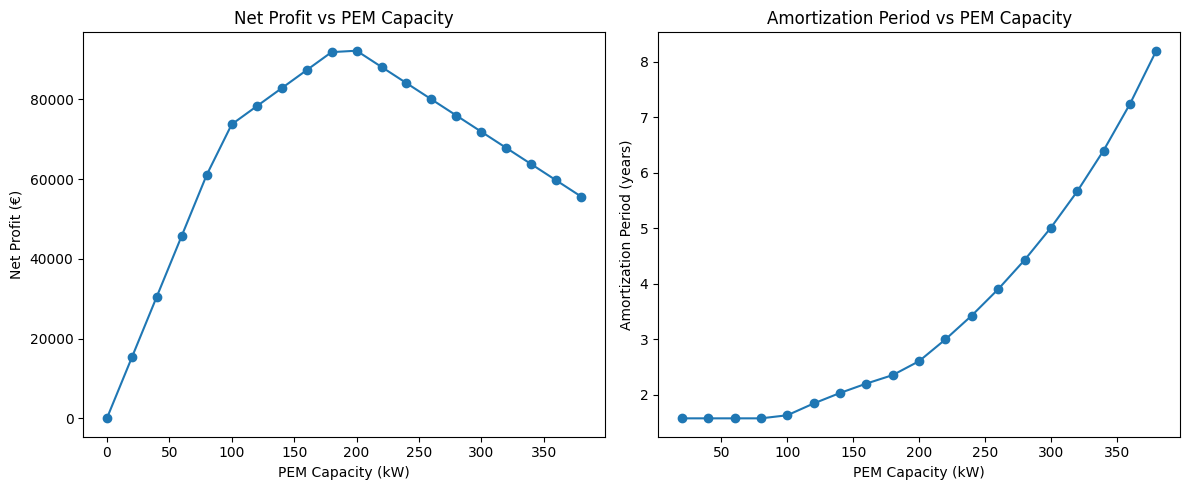

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load or simulate the electricity price data
# Simulated simple hourly data for 365 days
np.random.seed(42)
hours_per_year = 8760
timestamps = pd.date_range(start='2024-01-01', periods=hours_per_year, freq='H')
prices = np.clip(np.random.normal(loc=60, scale=20, size=hours_per_year), 0, None)  # €/MWh

df = pd.DataFrame({'timestamp': timestamps, 'price_eur_per_mwh': prices})

# Parameters
efficiency = 0.7
energy_content_per_kg_h2 = 33.3
interval_hours = 1.0
h2_sale_price = 5.0
h2_buy_price = 7.0
capex_per_kw = 1200

# Demand simulation
def simulate_demand(ts):
    hour = ts.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# Loop over different PEM capacities
results = []

for capacity_kw in range(0, 400, 20):
    max_price = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

    df['produce'] = df['price_eur_per_mwh'] <= max_price
    df['power_kw'] = df['produce'].astype(int) * capacity_kw
    df['energy_kwh'] = df['power_kw'] * interval_hours
    df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2
    df['actual_supply_kg'] = np.minimum(df['h2_demand_kg'], df['h2_kg'])
    df['unmet_demand_kg'] = (df['h2_demand_kg'] - df['actual_supply_kg']).clip(lower=0)

    df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)
    df['saved_costs_eur'] = df[['h2_kg', 'h2_demand_kg']].min(axis=1) * h2_buy_price
    df['profit_eur'] = df['saved_costs_eur'] - df['cost_eur']

    total_profit = df['profit_eur'].sum()
    total_capex = capacity_kw * capex_per_kw
    amortization_years = total_capex / total_profit if total_profit > 0 else np.inf

    results.append({
        'capacity_kw': capacity_kw,
        'total_profit': total_profit,
        'capex': total_capex,
        'amortization_years': amortization_years
    })

results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 5))

# Net profit
plt.subplot(1, 2, 1)
plt.plot(results_df['capacity_kw'], results_df['total_profit'], marker='o')
plt.title('Net Profit vs PEM Capacity')
plt.xlabel('PEM Capacity (kW)')
plt.ylabel('Net Profit (€)')

# Amortization
plt.subplot(1, 2, 2)
plt.plot(results_df['capacity_kw'], results_df['amortization_years'], marker='o')
plt.title('Amortization Period vs PEM Capacity')
plt.xlabel('PEM Capacity (kW)')
plt.ylabel('Amortization Period (years)')

plt.tight_layout()
plt.show()


**Preliminary Conclusion**
A good capacity seems to be around 200 kW. This significantly reduces the price.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------
# 1. Load input data
# ----------------------------

#historical data from https://www.smard.de/home/downloadcenter/download-marktdaten/
file = 'Gro_handelspreise_202401010000_202502050000_Stunde.csv'
df = pd.read_csv(file, delimiter=';')

# Extract relevant Rows for Germany 
df = df[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
df.rename(columns={'Datum von': 'ds', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'y'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['ds'], format='%d.%m.%Y %H:%M')
df['price_eur_per_mwh'] = df['y'].str.replace(',', '.').astype(float)
df.sort_values('ds', inplace=True)
#print (df)

# ----------------------------
# 2. Set technical and economic parameters
# ----------------------------

# Technical parameters
efficiency = 0.7  # PEM electrolyzer efficiency (70%)
energy_content_per_kg_h2 = 33.3  # energy content of H2 in kWh/kg
electrolyzer_capacity_kw = 200  # installed capacity in kW
interval_hours = 1.0  # time resolution of the dataset

# Economic parameters
h2_sale_price = 5.0  # €/kg - internal value per kg produced
h2_buy_price = 7.0   # €/kg - external market purchase price
capex_per_kw = 1200  # €/kW - investment cost of PEM capacity
simulation_years = 1  # simulation duration in years

# Determine maximum electricity price that allows profitable production
max_eur_per_mwh = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

# ----------------------------
# 3. Simulate H2 demand profile
# ----------------------------
def simulate_demand(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# ----------------------------
# 4. Agent logic: produce only when electricity is cheap enough
# ----------------------------
def should_produce(price_mwh):
    return price_mwh <= max_eur_per_mwh

df['produce'] = df['price_eur_per_mwh'].apply(should_produce)
df['power_kw'] = df['produce'].astype(int) * electrolyzer_capacity_kw
df['energy_kwh'] = df['power_kw'] * interval_hours
df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2

# ----------------------------
# 5. Calculate economics of production
# ----------------------------
df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)
df['saved_costs_eur'] = df[['h2_kg', 'h2_demand_kg']].min(axis=1) * h2_buy_price
df['profit_eur'] = df['saved_costs_eur'] - df['cost_eur']

# ----------------------------
# 6. Evaluate coverage of demand
# ----------------------------
# At this point: no storage or H2 purchase fallback — just what is produced
df['actual_supply_kg'] = np.minimum(df['h2_demand_kg'], df['h2_kg'])
df['unmet_demand_kg'] = df['h2_demand_kg'] - df['actual_supply_kg']
df['unmet_demand_kg'] = df['unmet_demand_kg'].clip(lower=0)

# ----------------------------
# 7. Evaluate investment and profitability
# ----------------------------
total_production = df['h2_kg'].sum()
total_demand = df['h2_demand_kg'].sum()
total_supplied = df['actual_supply_kg'].sum()
total_unmet = df['unmet_demand_kg'].sum()
total_cost = df['cost_eur'].sum()
total_saved = df['saved_costs_eur'].sum()
total_profit = df['profit_eur'].sum()
capex_total = electrolyzer_capacity_kw * capex_per_kw
amortization_years = capex_total / total_profit if total_profit > 0 else np.inf

# ----------------------------
# 8. Output summary
# ----------------------------
print("--- Simulation Summary ---")
print(f"Simulation period: {simulation_years} year(s)")
print(f"Installed PEM capacity: {electrolyzer_capacity_kw} kW")
print(f"Total CAPEX investment: {capex_total:,.2f} €")
print(f"Total H₂ production: {total_production:,.2f} kg")
print(f"Total H₂ demand: {total_demand:,.2f} kg")
print(f"Supplied from own production: {total_supplied:,.2f} kg")
print(f"Unmet demand (not covered): {total_unmet:,.2f} kg")
print(f"Total electricity cost: {total_cost:,.2f} €")
print(f"Cost savings (vs. buying at {h2_buy_price} €/kg): {total_saved:,.2f} €")
print(f"Net annual profit: {total_profit:,.2f} €")
print(f"Amortization period: {amortization_years:.2f} years")


--- Simulation Summary ---
Simulation period: 1 year(s)
Installed PEM capacity: 200 kW
Total CAPEX investment: 240,000.00 €
Total H₂ production: 38,090.09 kg
Total H₂ demand: 42,506.00 kg
Supplied from own production: 28,887.65 kg
Unmet demand (not covered): 13,618.35 kg
Total electricity cost: 134,259.29 €
Cost savings (vs. buying at 7.0 €/kg): 202,213.52 €
Net annual profit: 67,954.23 €
Amortization period: 3.53 years


**Preliminary Conclusion**
Assuming we install an electrolyzer, the system would yield a net annual profit of €67,954.23 with an amortization period of 3.53 years. Notably, this calculation excludes potential revenue from surplus hydrogen sales as well as the impact of storage integration. Given these promising baseline results, it is now both reasonable and necessary to explore these additional aspects in further detail.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------
# 1. Load input data
# ----------------------------

#historical data from https://www.smard.de/home/downloadcenter/download-marktdaten/
file = 'Gro_handelspreise_202401010000_202502050000_Stunde.csv'
df = pd.read_csv(file, delimiter=';')

# Extract relevant Rows for Germany 
df = df[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
df.rename(columns={'Datum von': 'ds', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'y'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['ds'], format='%d.%m.%Y %H:%M')
df['price_eur_per_mwh'] = df['y'].str.replace(',', '.').astype(float)
df.sort_values('ds', inplace=True)
#print (df)

# ----------------------------
# 2. Set technical and economic parameters
# ----------------------------

# Technical parameters
efficiency = 0.7  # PEM electrolyzer efficiency (70%)
energy_content_per_kg_h2 = 33.3  # energy content of H2 in kWh/kg
electrolyzer_capacity_kw = 200  # installed capacity in kW
interval_hours = 1.0  # time resolution of the dataset

# Economic parameters
h2_sale_price = 5.0  # €/kg - internal value per kg produced
h2_buy_price = 7.0   # €/kg - external market purchase price
capex_per_kw = 1200  # €/kW - investment cost of PEM capacity
simulation_years = 1  # simulation duration in years

# Determine maximum electricity price that allows profitable production
max_eur_per_mwh = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

# ----------------------------
# 3. Simulate H2 demand profile
# ----------------------------
def simulate_demand(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# ----------------------------
# 4. Agent logic: produce only when electricity is cheap enough
# ----------------------------
def should_produce(price_mwh):
    return price_mwh <= max_eur_per_mwh

df['produce'] = df['price_eur_per_mwh'].apply(should_produce)
df['power_kw'] = df['produce'].astype(int) * electrolyzer_capacity_kw
df['energy_kwh'] = df['power_kw'] * interval_hours
df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2

# ----------------------------
# 5. Calculate economics of production
# ----------------------------
df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)
df['used_h2_kg'] = np.minimum(df['h2_kg'], df['h2_demand_kg'])
df['saved_costs_eur'] = df['used_h2_kg'] * h2_buy_price
df['excess_h2_kg'] = (df['h2_kg'] - df['h2_demand_kg']).clip(lower=0)
df['revenue_from_sales'] = df['excess_h2_kg'] * h2_sale_price

#df['profit_eur'] = df['saved_costs_eur'] - df['cost_eur']
df['profit_eur'] = df['saved_costs_eur'] + df['revenue_from_sales'] - df['cost_eur']


# ----------------------------
# 6. Evaluate coverage of demand
# ----------------------------
# At this point: no storage or H2 purchase fallback — just what is produced
df['actual_supply_kg'] = np.minimum(df['h2_demand_kg'], df['h2_kg'])
df['unmet_demand_kg'] = df['h2_demand_kg'] - df['actual_supply_kg']
df['unmet_demand_kg'] = df['unmet_demand_kg'].clip(lower=0)

# ----------------------------
# 7. Evaluate investment and profitability
# ----------------------------
total_production = df['h2_kg'].sum()
total_demand = df['h2_demand_kg'].sum()
total_supplied = df['actual_supply_kg'].sum()
total_unmet = df['unmet_demand_kg'].sum()
total_cost = df['cost_eur'].sum()
total_saved = df['saved_costs_eur'].sum()
total_profit = df['profit_eur'].sum()
capex_total = electrolyzer_capacity_kw * capex_per_kw
amortization_years = capex_total / total_profit if total_profit > 0 else np.inf

# ----------------------------
# 8. Output summary
# ----------------------------
print("--- Simulation Summary ---")
print(f"Simulation period: {simulation_years} year(s)")
print(f"Installed PEM capacity: {electrolyzer_capacity_kw} kW")
print(f"Total CAPEX investment: {capex_total:,.2f} €")
print(f"Total H₂ production: {total_production:,.2f} kg")
print(f"Total H₂ demand: {total_demand:,.2f} kg")
print(f"Supplied from own production: {total_supplied:,.2f} kg")
print(f"Unmet demand (not covered): {total_unmet:,.2f} kg")
print(f"Total electricity cost: {total_cost:,.2f} €")
print(f"Cost savings (vs. buying at {h2_buy_price} €/kg): {total_saved:,.2f} €")
print(f"Net annual profit: {total_profit:,.2f} €")
print(f"Amortization period: {amortization_years:.2f} years")


--- Simulation Summary ---
Simulation period: 1 year(s)
Installed PEM capacity: 200 kW
Total CAPEX investment: 240,000.00 €
Total H₂ production: 38,090.09 kg
Total H₂ demand: 42,506.00 kg
Supplied from own production: 28,887.65 kg
Unmet demand (not covered): 13,618.35 kg
Total electricity cost: 134,259.29 €
Cost savings (vs. buying at 7.0 €/kg): 202,213.52 €
Net annual profit: 113,966.45 €
Amortization period: 2.11 years


**Preliminary Conclusion**
Selling surplus hydrogen gives rise to the net annual profit which is 113,966.45 € and reduces the amortization period to 2.11 years.

C:\Users\velpTEC edutainment\AppData\Local\Temp\ipykernel_13540\2827880375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2024-01-01', periods=hours_per_year, freq='H')


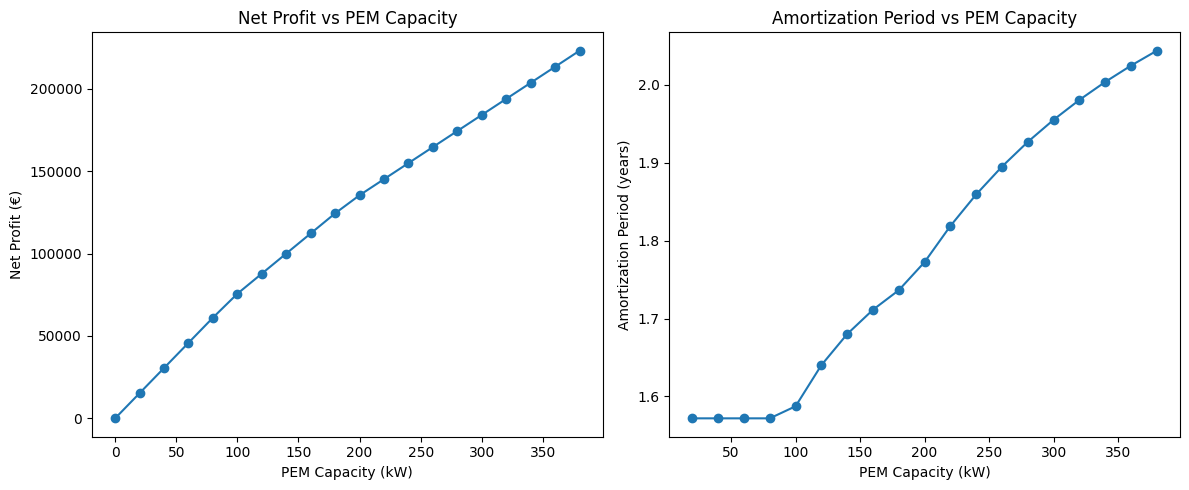

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load or simulate the electricity price data
# Simulated simple hourly data for 365 days
np.random.seed(42)
hours_per_year = 8760
timestamps = pd.date_range(start='2024-01-01', periods=hours_per_year, freq='H')
prices = np.clip(np.random.normal(loc=60, scale=20, size=hours_per_year), 0, None)  # €/MWh

df = pd.DataFrame({'timestamp': timestamps, 'price_eur_per_mwh': prices})

# Parameters
efficiency = 0.7
energy_content_per_kg_h2 = 33.3
interval_hours = 1.0
h2_sale_price = 5.0
h2_buy_price = 7.0
capex_per_kw = 1200

# Demand simulation
def simulate_demand(ts):
    hour = ts.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# Loop over different PEM capacities
results = []

for capacity_kw in range(0, 400, 20):
    max_price = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

    df['produce'] = df['price_eur_per_mwh'] <= max_price
    df['power_kw'] = df['produce'].astype(int) * capacity_kw
    df['energy_kwh'] = df['power_kw'] * interval_hours
    df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2
    df['actual_supply_kg'] = np.minimum(df['h2_demand_kg'], df['h2_kg'])
    df['unmet_demand_kg'] = (df['h2_demand_kg'] - df['actual_supply_kg']).clip(lower=0)

    df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)
    df['used_h2_kg'] = np.minimum(df['h2_kg'], df['h2_demand_kg'])
    df['saved_costs_eur'] = df['used_h2_kg'] * h2_buy_price
    df['excess_h2_kg'] = (df['h2_kg'] - df['h2_demand_kg']).clip(lower=0)
    df['revenue_from_sales'] = df['excess_h2_kg'] * h2_sale_price

    #df['profit_eur'] = df['saved_costs_eur'] - df['cost_eur']
    df['profit_eur'] = df['saved_costs_eur'] + df['revenue_from_sales'] - df['cost_eur']
    total_profit = df['profit_eur'].sum()
    total_capex = capacity_kw * capex_per_kw
    amortization_years = total_capex / total_profit if total_profit > 0 else np.inf

    results.append({
        'capacity_kw': capacity_kw,
        'total_profit': total_profit,
        'capex': total_capex,
        'amortization_years': amortization_years
    })

results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 5))

# Net profit
plt.subplot(1, 2, 1)
plt.plot(results_df['capacity_kw'], results_df['total_profit'], marker='o')
plt.title('Net Profit vs PEM Capacity')
plt.xlabel('PEM Capacity (kW)')
plt.ylabel('Net Profit (€)')

# Amortization
plt.subplot(1, 2, 2)
plt.plot(results_df['capacity_kw'], results_df['amortization_years'], marker='o')
plt.title('Amortization Period vs PEM Capacity')
plt.xlabel('PEM Capacity (kW)')
plt.ylabel('Amortization Period (years)')

plt.tight_layout()
plt.show()


### Why profit does not increase linearly with electrolyzer size

While a larger PEM capacity increases potential hydrogen production, the profit does **not** scale linearly due to:

* **Limited demand**: Once internal demand is covered, excess H₂ must be sold externally, often at lower or uncertain prices.
* **Decreasing utilization**: More capacity requires more cheap electricity hours, which are limited on the market.
* **Rising marginal costs**: Larger systems incur higher installation, maintenance, and grid connection costs.
* **Market constraints**: Oversupply and lack of guaranteed buyers reduce the value of surplus production.

**Conclusion**: Economically viable capacity is typically the size that covers internal demand with minimal oversupply.


C:\Users\velpTEC edutainment\AppData\Local\Temp\ipykernel_13540\2404748500.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2024-01-01', periods=n, freq='H')


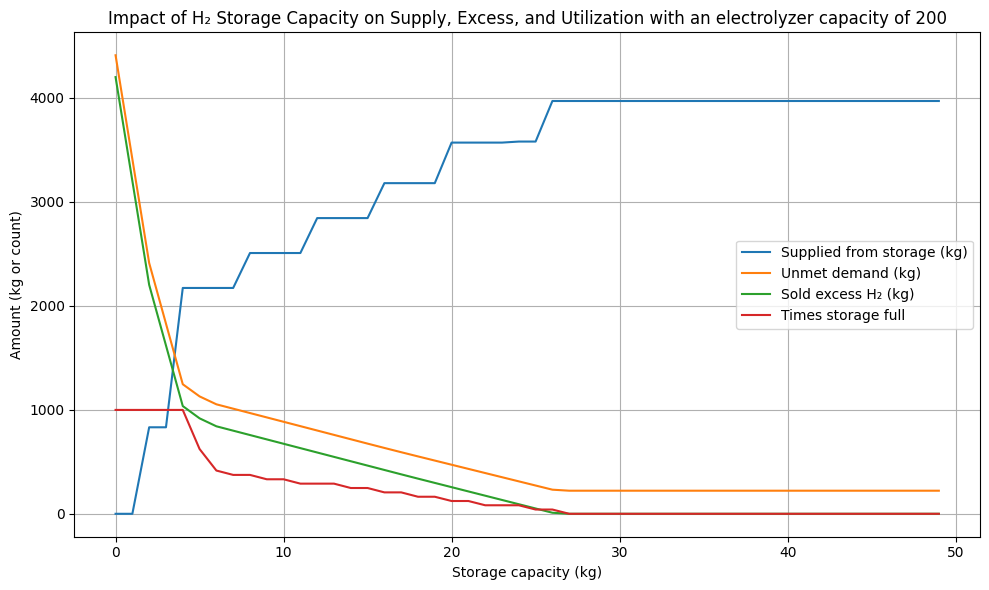

Empty DataFrame
Columns: [min_coverage_%, required_storage_kg, actual_coverage_%]
Index: []


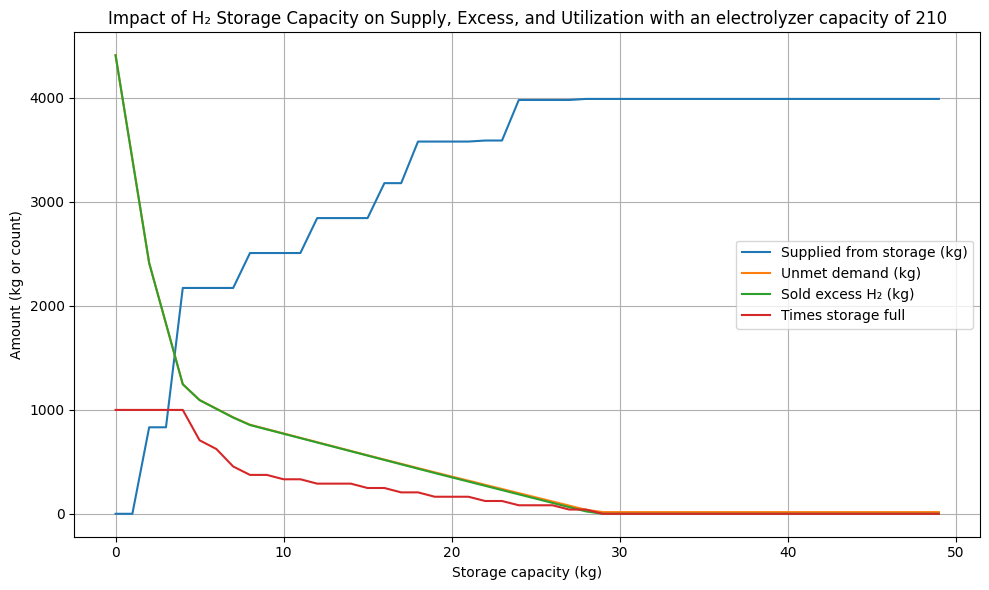

   min_coverage_%  required_storage_kg  actual_coverage_%
0              95                 24.0          99.343824
1              96                 24.0          99.343824
2              97                 24.0          99.343824
3              98                 24.0          99.343824
4              99                 24.0          99.343824


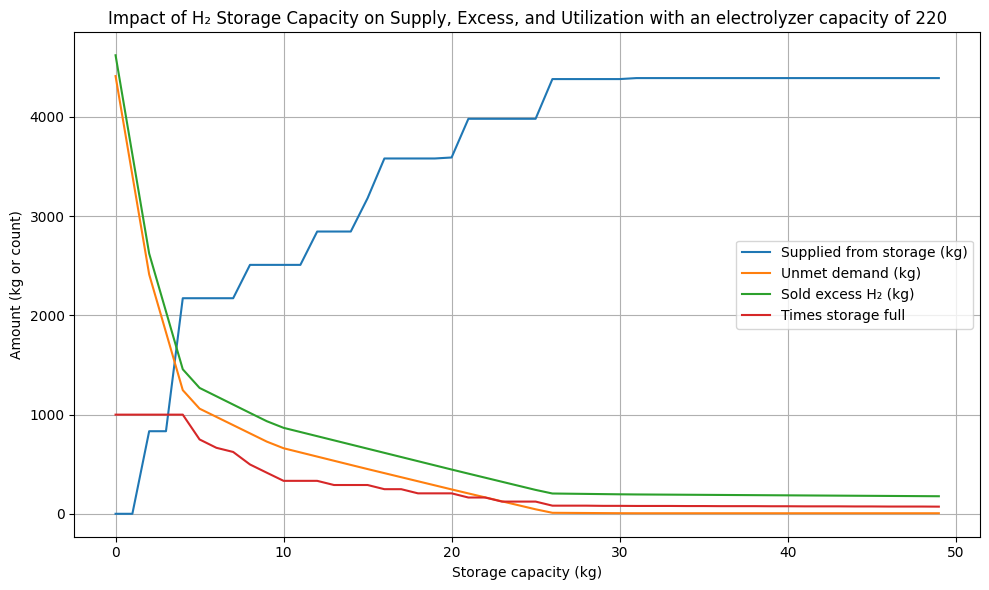

   min_coverage_%  required_storage_kg  actual_coverage_%
0              95                 26.0          99.647196
1              96                 26.0          99.647196
2              97                 26.0          99.647196
3              98                 26.0          99.647196
4              99                 26.0          99.647196


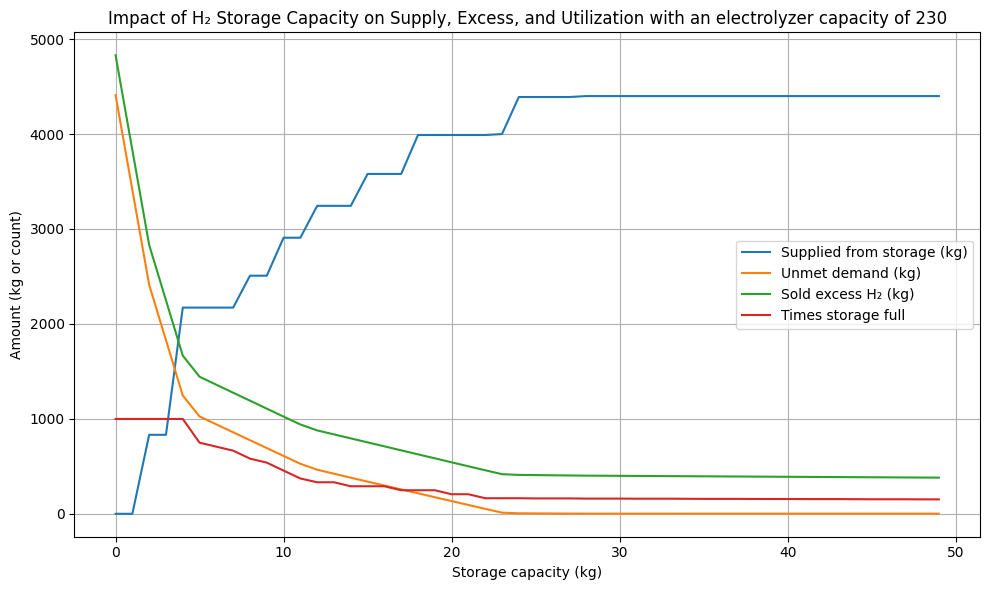

   min_coverage_%  required_storage_kg  actual_coverage_%
0              95                 24.0          99.743183
1              96                 24.0          99.743183
2              97                 24.0          99.743183
3              98                 24.0          99.743183
4              99                 24.0          99.743183


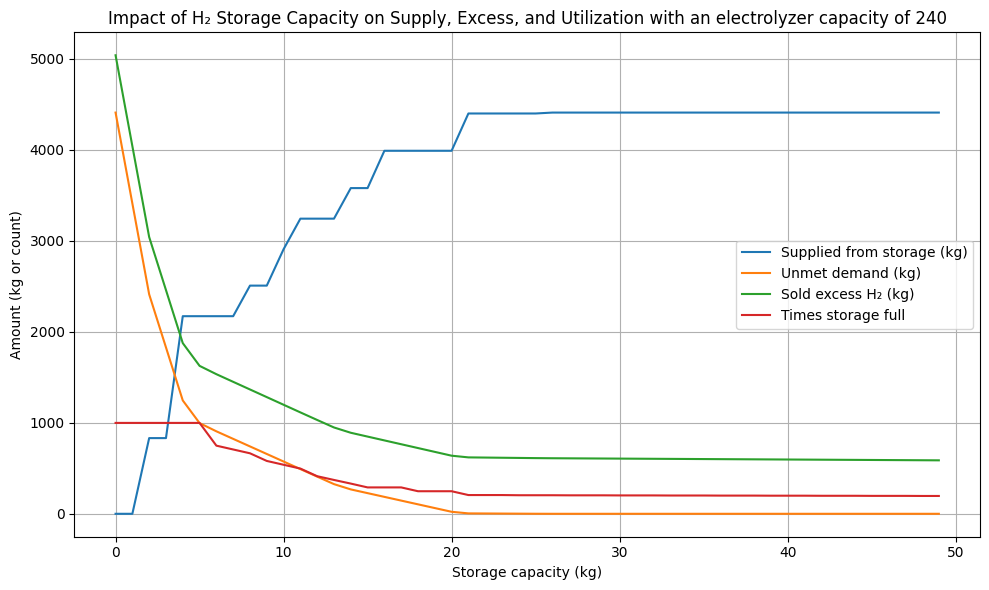

   min_coverage_%  required_storage_kg  actual_coverage_%
0              95                 21.0          99.773243
1              96                 21.0          99.773243
2              97                 21.0          99.773243
3              98                 21.0          99.773243
4              99                 21.0          99.773243
5             100                 26.0         100.000000


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
EFFICIENCY = 0.7
H2_ENERGY_CONTENT_KWH_PER_KG = 33.3
INTERVAL_HOURS = 1.0
H2_BUY_PRICE = 7.0
H2_SALE_PRICE = 5.0

MAX_EUR_PER_MWH = H2_BUY_PRICE * EFFICIENCY / H2_ENERGY_CONTENT_KWH_PER_KG * 1000

np.random.seed(42)
n = 1000
timestamps = pd.date_range(start='2024-01-01', periods=n, freq='H')
electricity_prices = np.clip(np.random.normal(loc=50, scale=30, size=n), -10, 150)  # €/MWh

def simulate_demand(ts):
    hour = ts.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2


#ELECTROLYZER_CAPACITY_KW = 200
capacities_kw = list(range(200, 250, 10))  # 
for ELECTROLYZER_CAPACITY_KW in capacities_kw:
 
    # DataFrame 
    df = pd.DataFrame({'timestamp': timestamps, 'price_eur_per_mwh': electricity_prices})
    df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)
    df['produce'] = df['price_eur_per_mwh'] <= MAX_EUR_PER_MWH
    df['power_kw'] = df['produce'].astype(int) * ELECTROLYZER_CAPACITY_KW
    df['energy_kwh'] = df['power_kw'] * INTERVAL_HOURS
    df['h2_kg'] = (df['energy_kwh'] * EFFICIENCY) / H2_ENERGY_CONTENT_KWH_PER_KG
    
    # Storage
    storage_results = []
    for max_storage in range(0, 50, 1):  # 
        storage = 0
        supplied_from_storage = 0
        supplied_from_direct = 0
        sold_excess = 0
        unmet_demand = 0
        full_counter = 0
    
        for _, row in df.iterrows():
            storage += row['h2_kg']
            if storage > max_storage:
                sold_excess += storage - max_storage
                storage = max_storage
                full_counter += 1
    
            if row['h2_demand_kg'] <= storage:
                storage -= row['h2_demand_kg']
                supplied_from_storage += row['h2_demand_kg']
            else:
                supplied_from_direct += storage
                unmet_demand += row['h2_demand_kg'] - storage
                storage = 0
    
        storage_results.append({
            'storage_capacity': max_storage,
            'supplied': supplied_from_storage,
            'unmet': unmet_demand,
            'sold_excess': sold_excess,
            'full_count': full_counter
        })
    
    storage_df = pd.DataFrame(storage_results)
    # Plot 
    plt.figure(figsize=(10, 6))
    
    plt.plot(storage_df['storage_capacity'], storage_df['supplied'], label='Supplied from storage (kg)')
    plt.plot(storage_df['storage_capacity'], storage_df['unmet'], label='Unmet demand (kg)')
    plt.plot(storage_df['storage_capacity'], storage_df['sold_excess'], label='Sold excess H₂ (kg)')
    plt.plot(storage_df['storage_capacity'], storage_df['full_count'], label='Times storage full')
    
    plt.xlabel('Storage capacity (kg)')
    plt.ylabel('Amount (kg or count)')
    plt.title('Impact of H₂ Storage Capacity on Supply, Excess, and Utilization with an electrolyzer capacity of ' + str(ELECTROLYZER_CAPACITY_KW))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




    # 
    total_demand = storage_df['supplied'].max() + storage_df['unmet'].min()
    
    # Calculate the percentage of demand covered for each storage capacity
    storage_df['coverage_percent'] = 100 * storage_df['supplied'] / total_demand
    
    # Filter only the relevant threshold values
    thresholds = [95, 96, 97, 98, 99, 100]
    coverage_table = storage_df[storage_df['coverage_percent'].round().isin(thresholds)][['storage_capacity', 'coverage_percent']]
    
    coverage_table.sort_values(by='coverage_percent', inplace=True)
    coverage_table.drop_duplicates('coverage_percent', inplace=True)
    coverage_table.reset_index(drop=True, inplace=True)
    
    # Find the smallest storage capacity that achieves at least X% self-sufficiency
    result_rows = []
    for threshold in thresholds:
        subset = storage_df[storage_df['coverage_percent'] >= threshold]
        if not subset.empty:
            min_row = subset.iloc[0]
            result_rows.append((threshold, min_row['storage_capacity'], min_row['coverage_percent']))
    
    # DataFrame 
    threshold_df = pd.DataFrame(result_rows, columns=['min_coverage_%', 'required_storage_kg', 'actual_coverage_%'])
    print(    threshold_df)


**Problem Identification**

Even with an oversized storage system, a 200 kW electrolyzer fails to meet more than 94.7% of the hydrogen demand — indicating that production capacity, not storage, is the limiting factor.

**Proposed Solution**

By increasing the electrolyzer capacity to 210 kW and adding a modest 24 kg storage unit, the system achieves 99.3% coverage of total demand. This configuration represents our recommended solution.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load input data ---
file = 'Gro_handelspreise_202401010000_202502050000_Stunde.csv'
df = pd.read_csv(file, delimiter=';')

# Extract relevant rows and convert types
df = df[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
df.rename(columns={'Datum von': 'ds', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'y'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['ds'], format='%d.%m.%Y %H:%M')
df['price_eur_per_mwh'] = df['y'].str.replace(',', '.').astype(float)
df.sort_values('ds', inplace=True)

# --- 2. Set technical and economic parameters ---
efficiency = 0.7
energy_content_per_kg_h2 = 33.3
electrolyzer_capacity_kw = 210
interval_hours = 1.0

h2_sale_price = 5.0
h2_buy_price = 7.0
capex_per_kw = 1200
simulation_years = 1

max_eur_per_mwh = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

# --- 3. Simulate H2 demand profile ---
def simulate_demand(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# --- 4. Agent logic ---
df['produce'] = df['price_eur_per_mwh'] <= max_eur_per_mwh
df['power_kw'] = df['produce'].astype(int) * electrolyzer_capacity_kw
df['energy_kwh'] = df['power_kw'] * interval_hours
df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2

# --- 5. Calculate economics of production ---
df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)
df['used_h2_kg'] = np.minimum(df['h2_kg'], df['h2_demand_kg'])
df['saved_costs_eur'] = df['used_h2_kg'] * h2_buy_price
df['excess_h2_kg'] = (df['h2_kg'] - df['h2_demand_kg']).clip(lower=0)
df['revenue_from_sales'] = df['excess_h2_kg'] * h2_sale_price
df['profit_eur'] = df['saved_costs_eur'] + df['revenue_from_sales'] - df['cost_eur']

# --- 6. Evaluate coverage of demand ---
df['actual_supply_kg'] = np.minimum(df['h2_demand_kg'], df['h2_kg'])
df['unmet_demand_kg'] = (df['h2_demand_kg'] - df['actual_supply_kg']).clip(lower=0)

# --- 7. Evaluate investment and profitability ---
total_production = df['h2_kg'].sum()
total_demand = df['h2_demand_kg'].sum()
total_supplied = df['actual_supply_kg'].sum()
total_unmet = df['unmet_demand_kg'].sum()
total_cost = df['cost_eur'].sum()
total_saved = df['saved_costs_eur'].sum()
total_profit = df['profit_eur'].sum()
capex_total = electrolyzer_capacity_kw * capex_per_kw
amortization_years = capex_total / total_profit if total_profit > 0 else np.inf

# Store key results for display

print("--- Simulation Summary ---")
print(f"Simulation period: {simulation_years} year(s)")
print(f"Installed PEM capacity: {electrolyzer_capacity_kw} kW")
print(f"Total CAPEX investment: {capex_total:,.2f} €")
print(f"Total H₂ production: {total_production:,.2f} kg")
print(f"Total H₂ demand: {total_demand:,.2f} kg")
print(f"Supplied from own production: {total_supplied:,.2f} kg")
print(f"Unmet demand (not covered): {total_unmet:,.2f} kg")
print(f"Total electricity cost: {total_cost:,.2f} €")
print(f"Cost savings (vs. buying at {h2_buy_price} €/kg): {total_saved:,.2f} €")
print(f"Net annual profit: {total_profit:,.2f} €")
print(f"Amortization period: {amortization_years:.2f} years")


--- Simulation Summary ---
Simulation period: 1 year(s)
Installed PEM capacity: 210 kW
Total CAPEX investment: 252,000.00 €
Total H₂ production: 39,994.59 kg
Total H₂ demand: 42,506.00 kg
Supplied from own production: 29,329.93 kg
Unmet demand (not covered): 13,176.07 kg
Total electricity cost: 140,972.26 €
Cost savings (vs. buying at 7.0 €/kg): 205,309.50 €
Net annual profit: 117,660.57 €
Amortization period: 2.14 years


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load input data
# ----------------------------
file_path = "Gro_handelspreise_202401010000_202502050000_Stunde.csv"
df = pd.read_csv(file_path, delimiter=';')

df = df[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
df.rename(columns={'Datum von': 'ds', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'y'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['ds'], format='%d.%m.%Y %H:%M')
df['price_eur_per_mwh'] = df['y'].str.replace(',', '.').astype(float)
df.sort_values('timestamp', inplace=True)

# ----------------------------
# 2. Set technical and economic parameters
# ----------------------------
efficiency = 0.7  # 70% PEM efficiency
energy_content_per_kg_h2 = 33.3  # in kWh/kg
electrolyzer_capacity_kw = 210
interval_hours = 1.0
h2_sale_price = 5.0  # €/kg
h2_buy_price = 7.0   # €/kg
capex_per_kw = 1200  # €/kW
storage_capacity_kg = 24.0  # in kg
simulation_years = 1

capex_per_kgH2 = 1200 # €/kg

max_eur_per_mwh = h2_buy_price * efficiency / energy_content_per_kg_h2 * 1000

# ----------------------------
# 3. Simulate H2 demand
# ----------------------------
def simulate_demand(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 9:
        return 8
    elif 17 <= hour < 20:
        return 10
    elif 9 <= hour < 17:
        return 4
    else:
        return 2

df['h2_demand_kg'] = df['timestamp'].apply(simulate_demand)

# ----------------------------
# 4. Agent logic
# ----------------------------
df['produce'] = df['price_eur_per_mwh'] <= max_eur_per_mwh
df['power_kw'] = df['produce'].astype(int) * electrolyzer_capacity_kw
df['energy_kwh'] = df['power_kw'] * interval_hours
df['h2_kg'] = (df['energy_kwh'] * efficiency) / energy_content_per_kg_h2

# ----------------------------
# 5. Simulate storage behavior
# ----------------------------
storage_level = 0.0
storage_series = []
actual_supply = []

for _, row in df.iterrows():
    produced = row['h2_kg']
    demand = row['h2_demand_kg']
    supply = min(produced + storage_level, demand)
    used_from_storage = max(0.0, demand - produced)
    storage_level = max(0.0, min(storage_capacity_kg, storage_level + produced - demand))
    storage_series.append(storage_level)
    actual_supply.append(supply)

df['storage_level_kg'] = storage_series
df['actual_supply_kg'] = actual_supply
df['unmet_demand_kg'] = df['h2_demand_kg'] - df['actual_supply_kg']
df['unmet_demand_kg'] = df['unmet_demand_kg'].clip(lower=0)

# ----------------------------
# 6. Economics
# ----------------------------
df['used_h2_kg'] = df['actual_supply_kg']
df['excess_h2_kg'] = np.maximum(0, df['h2_kg'] - (df['actual_supply_kg'] - df['storage_level_kg'].diff().fillna(0)))
df['revenue_from_sales'] = df['excess_h2_kg'] * h2_sale_price
df['cost_eur'] = df['energy_kwh'] * (df['price_eur_per_mwh'] / 1000)

df['saved_costs_eur'] = df['used_h2_kg'] * h2_buy_price
df['profit_eur'] = df['saved_costs_eur'] + df['revenue_from_sales'] - df['cost_eur']

# ----------------------------
# 7. Evaluation
# ----------------------------
total_production = df['h2_kg'].sum()
total_demand = df['h2_demand_kg'].sum()
total_supplied = df['actual_supply_kg'].sum()
total_unmet = df['unmet_demand_kg'].sum()
total_cost = df['cost_eur'].sum()
total_saved = df['saved_costs_eur'].sum()
total_profit = df['profit_eur'].sum()
capex_total = electrolyzer_capacity_kw * capex_per_kw  + storage_capacity_kg * capex_per_kgH2 #cost electrolyzer and storage
amortization_years = capex_total / total_profit if total_profit > 0 else np.inf

# ----------------------------
# 8. Output summary
# ----------------------------
print("--- Simulation Summary ---")
print(f"Simulation period: {simulation_years} year(s)")
print(f"Installed PEM capacity: {electrolyzer_capacity_kw} kW")
print(f"Storage capacity: {storage_capacity_kg} kg")
print(f"Total CAPEX investment: {capex_total:,.2f} €")
print(f"Total H₂ production: {total_production:,.2f} kg")
print(f"Total H₂ demand: {total_demand:,.2f} kg")
print(f"Supplied from own production + storage: {total_supplied:,.2f} kg")
print(f"Unmet demand (not covered): {total_unmet:,.2f} kg")
print(f"Total electricity cost: {total_cost:,.2f} €")
print(f"Cost savings (vs. buying at {h2_buy_price} €/kg): {total_saved:,.2f} €")
print(f"Net annual profit: {total_profit:,.2f} €")
print(f"Amortization period: {amortization_years:.2f} years")


--- Simulation Summary ---
Simulation period: 1 year(s)
Installed PEM capacity: 210 kW
Storage capacity: 24.0 kg
Total CAPEX investment: 280,800.00 €
Total H₂ production: 39,994.59 kg
Total H₂ demand: 42,506.00 kg
Supplied from own production + storage: 39,936.54 kg
Unmet demand (not covered): 2,569.46 kg
Total electricity cost: 140,972.26 €
Cost savings (vs. buying at 7.0 €/kg): 279,555.78 €
Net annual profit: 244,976.14 €
Amortization period: 1.15 years


Comment: Here also the cost for the storage is included.

**Executive Summary**

Based on the current electricity price data and an assumed internal hydrogen demand profile, our simulation strongly suggests that building a 210 kW PEM electrolyzer with 24 kg of hydrogen storage is economically beneficial. The net annual profit is estimated at €244,976.14, leading to a payback period of only 1.15 years, even under conservative assumptions. This includes internal cost savings from avoided H₂ purchases and revenue from surplus sales.

The setup allows 99.3% of hydrogen demand to be covered using self-produced hydrogen and storage, reducing reliance on the external hydrogen market and shielding the operation from future price volatility. The system also unlocks value from periods of low electricity prices by producing excess hydrogen for sale or later use.

Given this attractive return on investment, low amortization time, and high self-sufficiency, we recommend moving forward with concrete planning, technical design, and obtaining supplier offers. Including installation, safety infrastructure, permitting, and control systems, a realistic full cost (CAPEX) could range between €350,000 and €450,000, depending on site-specific factors and regulatory requirements.

**Model & Code Summary**

This simulation model was developed in Python and performs an hourly analysis of electricity prices over a one-year period. It simulates hydrogen production by a PEM electrolyzer with configurable capacity and evaluates:

    Demand coverage based on a realistic daily consumption profile.

    Production decisions based on electricity price thresholds.

    Economic viability through cost savings, sales revenue, and capital expenditure.

The model includes:

    Flexible parameters for electrolyzer size and storage capacity.

    Detailed tracking of production, consumption, and surplus.

    Profitability assessment via cumulative profit and amortization time.

    Visual plots for price, production vs. demand, and profit development over time.

This code can be easily adapted for new datasets, different market conditions, or alternative system designs. It serves as a strong basis for techno-economic feasibility studies and early-stage project planning for green hydrogen systems.